In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch 
from torch.autograd import Variable 
import torch.optim as optim 
from torch.utils.data import DataLoader 
from torchvision import transforms
import csv
from torch.utils.data.dataset import Dataset 
import torch.nn as nn 
import torch.nn.functional as F

# 1. Load the data

subroutine.py

In [3]:
import csv
def return_HM_npy(csvfile_path):
    H=[]
    M=[]
    with open(csvfile_path, 'r') as f:
        reader=csv.reader(f)
        header=next(reader) #skip header
        for row in reader:
            H.append(float(row[0]))
            M.append(float(row[1]))
    return np.array(H), np.array(M)

def accept_middle(H, M, noise_std=0.1, f=None):
    noise=abs(np.random.normal(0, noise_std))
    if (f(H)-noise < M) and (M < f(H)+noise):
        return True
    else: return False

def generate_data(noise_std=0.1, datasize=10000, Hrange=[0.0, 6.0], Mrange=[0.0, 2.0], f=None):
    Hp=[]
    Mp=[]
    Fp=[]
    Hn=[]
    Mn=[]
    Fn=[]
    while True:
        H=np.random.uniform(Hrange[0], Hrange[1])
        M=np.random.uniform(Mrange[0], Mrange[1])
        if accept_middle(H, M, noise_std, f) and len(Hp)<datasize:
            Hp.append([H])
            Mp.append([M])
            Fp.append([0])
        elif len(Hn)<datasize:
            Hn.append([H])
            Mn.append([M])
            Fn.append([1])
        if len(Hp)>=datasize and len(Hn)>=datasize:
            break
    return (np.array(Hp), np.array(Mp), np.array(Fp)), (np.array(Hn), np.array(Mn), np.array(Fn))

def plot_all(H, M, Positive_HM, Negative_HM, f):
    plt.xlabel('H')
    plt.ylabel('M')
    plt.plot(Negative_HM[0], Negative_HM[1], 'y.', label='negative')
    plt.plot(Positive_HM[0], Positive_HM[1], 'b.', label='positive')
    hs=np.linspace(np.min(H), np.max(H), 100)
    plt.plot(hs, f(hs), 'k-', label='data fitting')
    plt.plot(H, M, 'ro', label='data')
    plt.legend(loc='upper right',bbox_to_anchor=(1.05, 0.5, 0.5, .100))
    plt.show()

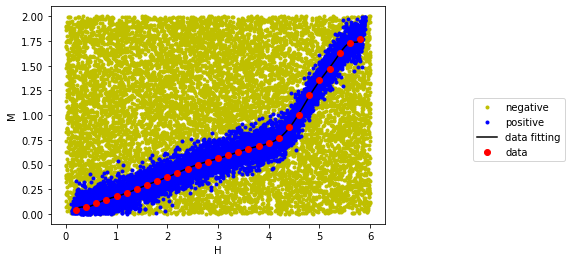

In [4]:
H,M=return_HM_npy('MHfile.csv')
f=np.poly1d(np.polyfit(H,M,deg=15))
Positive_HM, Negative_HM = generate_data(datasize=10000, f=f)
plot_all(H, M, Positive_HM, Negative_HM, f)

## Reformat training data
Make training data by class called 'Dataset'.

In [5]:
class phi_pi_dataset:
    def __init__(self, Positive_HM, Negative_HM, transform=None):
        self.phi=np.concatenate((Positive_HM[0], Negative_HM[0]), axis=0).astype(np.float32)
        self.pi=np.concatenate((Positive_HM[1], Negative_HM[1]), axis=0).astype(np.float32)
        self.ans = np.concatenate((Positive_HM[2], Negative_HM[2]), axis=0).astype(np.float32)
        self.transform=transform
    def __getitem__(self, index):
        phi=self.phi[index]
        pi=self.pi[index]
        ans = self.ans[index]
        if self.transform is not None:
            phi=self.transform(phi)
            pi=self.transform(pi)
            ans = self.transform(ans)
        return phi, pi, ans
    def __len__(self):
        return len(self.phi)

In [6]:
train_d_loader = DataLoader(phi_pi_dataset(
                                Positive_HM=Positive_HM, 
                                Negative_HM=Negative_HM, 
                                transform=transforms.Compose([torch.from_numpy])), 
                                batch_size=100, shuffle=True)

# 2. Make a Neural network
neuralnet.py

In [18]:
import torch.nn as nn
import torch.nn.functional as F

def onestep(phi, pi, hh=None, m2=None, lamb=None, del_eta=None):
    phi1 = phi + del_eta*pi
    pi1 = phi*m2*del_eta + (1-del_eta*hh)*pi + del_eta*lamb*(phi1**3)
    return phi1, pi1

def eta(s, eta_ini, eta_fin, N_layer):
    eta = eta_ini + (eta_fin - eta_ini)*(s-1)/N_layer
    return eta

# functions in final layers

def f(phi, pi, eta=None):
    ''' returning Pi'''
    F=pi
    return F

def arctan_scaled(x, center=None, scale=10, tanh=None):
    y = scale*(x-center)
    y = tanh(y)
    return y

def t(x, epsilon=None, tanh=None, dev=.01):
    ''' smoothed bump function '''
    left = -arctan_scaled(x, center=-epsilon, scale=1/dev, tanh=tanh)
    right = arctan_scaled(x, center=epsilon, scale=1/dev, tanh=tanh)
    lf = left+right
    return (lf+2)/2

class Metricnet(nn.Module):
    def __init__(self, N_layer=None, eta_ini=None, eta_fin=None, del_eta=None, d=None):
        super(Metricnet, self).__init__()
        
        #trained parameters
        Hs=[]
        for layer_index in range (N_layer):
            Hs.append(nn.Linear(1, 1, bias=False))
        self.Hs=nn.ModuleList(Hs)
        self.lamb=nn.Linear(1, 1, bias=False)
        self.m2=nn.Linear(1, 1, bias=False)
        self.alpha=nn.Linear(1, 1, bias=False)
        self.beta=nn.Linear(1, 1, bias=False)
        
        #fixed parameters
        self.N_layer=N_layer
        self.eta_ini=eta_ini
        self.eta_fin=eta_fin
        self.del_eta=del_eta
        self.d=d
        self.one=Variable(torch.ones(1))
        
    def show_lamb(self):
        return self.lamb(self.one)
    def show_m2(self):
        return self.m2(self.one)
    def show_alpha(self):
        return self.alpha(self.one)
    def show_beta(self):
        return self.beta(self.one)
    
    def penalty(self, coef_list=None):
        penalty=0
        if coef_list==None:
            coefs = torch.autograd.Variable(torch.ones(self.N_layer))
        else:
            n_coef_list = np.array(coef_list, dtype=np.float32)
            coefs = torch.autograd.Variable(torch.from_numpy(n_coef_list))
        pH=self.Hs[0](self.one)
        for i in range(1, self.N_layer):
            H = self.Hs[i]
            if H==self.Hs[9]:
                # making the metric at boundary as AdS_{d+1} 
                penalty = penalty + c_reg2*(1/self.eta_fin - H(self.one))**2
            else:
                # smoothing penalty
                ## if Einstein equation, use below:
                #penalty = penalty + coefs[i]*(-d**2 + (H(self.one) - pH)/del_eta + pH**2)**2
                penalty = penalty + coefs[i]*(H(self.one) - pH)**2
                pH = H(self.one)
        return penalty
    
    def forward(self, H=None, M=None):
        #initial layer
        D=torch.sqrt(torch.abs(1+4*self.m2(self.one)/(self.Hs[0](self.one)**2)))
        phi=self.alpha(self.one)*H + self.beta(self.one)*M
        pi=(d/2)*(D-1)*self.alpha(self.one)*H + (d/2)*(-D-1)*self.beta(self.one)*M
        for i in range (self.N_layer-1):
            phi, pi = onestep(phi, pi, hh=self.Hs[i](self.one), m2=self.m2(self.one), 
                              lamb=self.lamb(self.one), del_eta=self.del_eta)
        ff=f(phi, pi, eta=eta(self.N_layer, self.eta_ini, self.eta_fin, self.N_layer))
        final = t(ff, epsilon=.1, tanh=torch.tanh)
        return final
    
    def loss(self, phi=None, pi=None, answer=None, reg_coef_list=None):
        model_output=self.forward(H=phi, M=pi)
        loss=F.l1_loss(model_output, answer)**2
        loss=loss+self.penalty(coef_list=reg_coef_list)
        return loss

def init_weights(Model, d):
    for i in range (len(Model.Hs)):
        w=np.random.normal(2, 1)
        Model.Hs[i].weight.data.fill_(w)
    m2=np.random.normal(2, 1)
    lamb=np.random.normal(1, 1)
    alpha=np.random.uniform(-0.5, 0.5)
    beta=np.random.uniform(-0.5, 0.5)
    Model.m2.weight.data.fill_(m2)
    Model.lamb.weight.data.fill_(lamb)
    Model.alpha.weight.data.fill_(alpha)
    Model.beta.weight.data.fill_(beta)    

In [19]:
d=4
N_layer=10
eta_fin=1/N_layer
eta_ini=1
del_eta=(eta_fin-eta_ini)/N_layer
c_reg1=0.01
c_reg2=0.0001

#make network
Test=Metricnet(N_layer=N_layer, eta_ini=eta_ini, eta_fin=eta_fin, del_eta=del_eta, d=d)
init_weights(Test, d)
optimizer = torch.optim.Adam(Test.parameters())
Test.train()
regularization_coeffs = [0] #(np.array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1])*0.001).tolist()
for i in range(1, N_layer):
    regularization_coeffs.append(c_reg1*eta(i, eta_ini, eta_fin, N_layer)**4)
    
a=[Test.Hs[i](Test.one).data.numpy()[0] for i in range (Test.N_layer)]
print("H: ", np.array(a))
print ("m2: {}, lambda: {}, alpha: {}, beta: {}".format(Test.show_m2().data.numpy()[0], Test.show_lamb().data.numpy()[0], Test.show_alpha().data.numpy()[0], Test.show_beta().data.numpy()[0]))

H:  [ 2.3502264  1.0428587  0.5792587  0.6144843 -1.5652493  1.305468
  3.0031931  1.0048976  2.6317987  1.688131 ]
m2: 0.6148775815963745, lambda: 0.7388117909431458, alpha: 0.48840662837028503, beta: 0.01496334932744503


# 3. Train NN

In [20]:
def plot_phase_and_metric(threshold=None, eta_or_layer='eta', positive_H_M_F=None, negative_H_M_F=None, Net=None):
    NN2_pos_phis = []
    NN2_pos_Pis = []
    
    negative_H = negative_H_M_F[0] #input_data[1]
    negative_M = negative_H_M_F[1] #input_data[3]
    
    phis = Variable(torch.from_numpy(negative_H.astype(np.float32)))
    Pis = Variable(torch.from_numpy(negative_M.astype(np.float32)))
    NN2_predicts = Net.forward(H=phis, M=Pis).data.numpy()

    for index in range(len(phis)):
        value = NN2_predicts[index]#NN2.predict([phis[index], Pis[index]])
        if value < threshold:
            NN2_pos_phis.append(negative_H[index])
            NN2_pos_Pis.append(negative_M[index])
        
    NN2_pos_phis_1 = np.array(NN2_pos_phis)
    NN2_pos_Pis_1 = np.array(NN2_pos_Pis)
    ######
    NN2_pos_phis = []
    NN2_pos_Pis = []
    
    positive_H = positive_H_M_F[0]# input_data[0]
    positive_M = positive_H_M_F[1]# input_data[2]
    
    phis = Variable(torch.from_numpy(positive_H.astype(np.float32)))
    Pis = Variable(torch.from_numpy(positive_M.astype(np.float32)))
    NN2_predicts = Net.forward(H=phis, M=Pis).data.numpy()

    for index in range(len(phis)):
        value = NN2_predicts[index]#NN2.predict([phis[index], Pis[index]])
        if value < threshold:
            NN2_pos_phis.append(positive_H[index])
            NN2_pos_Pis.append(positive_M[index])
        
    NN2_pos_phis_2 = np.array(NN2_pos_phis)
    NN2_pos_Pis_2 = np.array(NN2_pos_Pis)
    ####
    plt.rcParams["font.size"] = 12
    fig = plt.figure(figsize=(14, 4))
    fig.subplots_adjust(bottom=0.15)
    al = fig.add_subplot(1,2,1)
    ar = fig.add_subplot(1,2,2)
    al.set_xlabel('M', fontsize=12)
    al.set_ylabel('H', fontsize=12)
    al.plot(positive_H , positive_M, 'b.', label='Positive')
    #print(NN2_pos_phis_1)
    al.plot(NN2_pos_phis_1 , NN2_pos_Pis_1, 'm.', label='NN(negative)=0')
    al.plot(NN2_pos_phis_2 , NN2_pos_Pis_2, 'r.', label='NN(positive)=0')
    al.tick_params(labelsize=12)
    #al.legend(loc="upper left")
    ##
    if eta_or_layer=='eta':
        x = etas
        ar.set_xlabel('eta', fontsize=12)
    else:
        x = np.arange(0,Net.N_layer,1)
        ar.set_xlabel('layer', fontsize=12)
    NN2_list = []
    for param in Net.Hs.parameters():
        w_py = (param.data.numpy().reshape(-1)).tolist()
        NN2_list.append(w_py)
    ar.set_ylabel('metric (H[layer])', fontsize=12)
    ar.plot(x, np.array(NN2_list), 'b-')#label='Emergent metric',lw=5, alpha=0.5)#/NN_list[0])
    ar.tick_params(labelsize=12)
    plt.show()
    return NN2_pos_phis_1, NN2_pos_Pis_1, NN2_pos_phis_2, NN2_pos_Pis_2, NN2_list

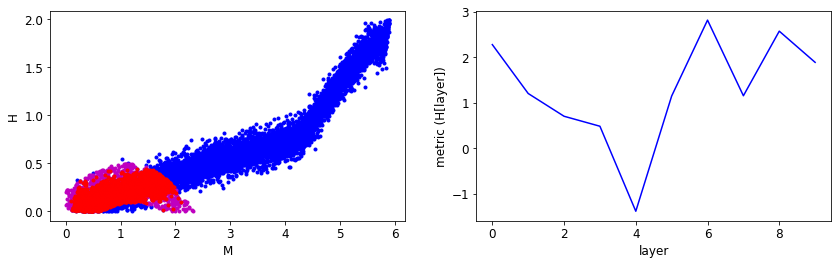

training epoch: 0,   loss: 0.22171062231063843
m2: 0.6800504326820374, lambda: 0.6603181958198547, alpha: 0.39641910791397095, beta: 0.029709499329328537
[ 2.2768054   1.20333219  0.70340049  0.48413882 -1.38242471  1.14767909
  2.81466103  1.15381503  2.57190418  1.88715315]


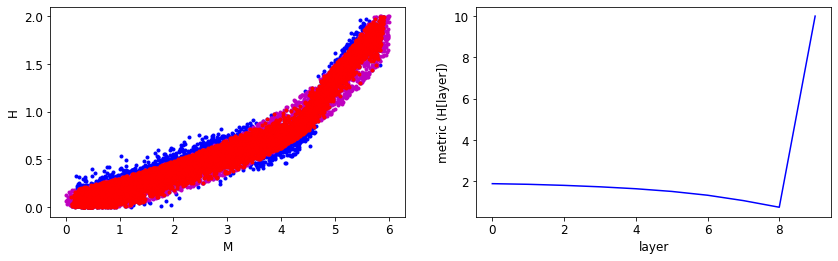

training epoch: 100,   loss: 0.010165688581764698
m2: 0.3506182134151459, lambda: -1.0484641790390015, alpha: 0.10870777070522308, beta: 0.036691583693027496
[1.88696396 1.85602188 1.80466354 1.73482203 1.64124823 1.51161659
 1.32730079 1.06673014 0.74528027 9.99999714]


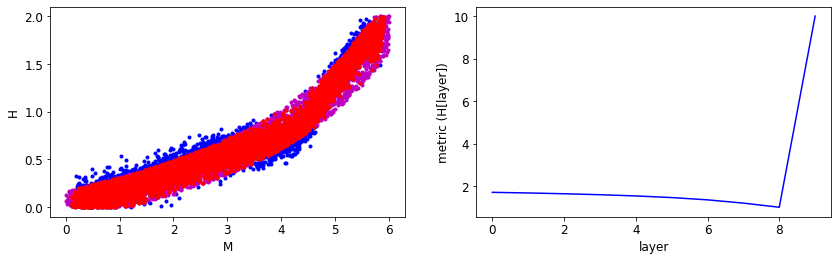

training epoch: 200,   loss: 0.010033227503299713
m2: 0.2674252688884735, lambda: -0.9926961064338684, alpha: 0.10793807357549667, beta: 0.03710658848285675
[ 1.72101021  1.69146061  1.65461528  1.60948086  1.55214155  1.47545433
  1.36775553  1.21432817  1.02078748 10.        ]


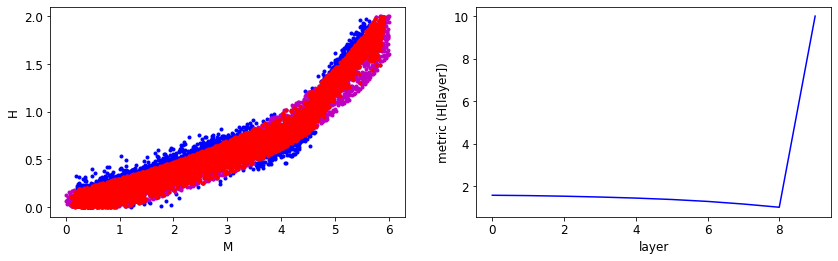

training epoch: 300,   loss: 0.00979460496455431
m2: 0.2358366698026657, lambda: -0.9224076271057129, alpha: 0.11068688333034515, beta: 0.04229608178138733
[ 1.58133423  1.56515861  1.53682446  1.49791217  1.44856298  1.38244069
  1.29196966  1.16861391  1.0179112  10.        ]


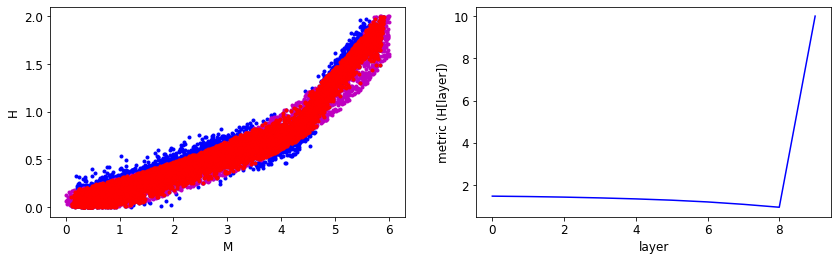

training epoch: 400,   loss: 0.00951379630714655
m2: 0.20312941074371338, lambda: -0.8446884155273438, alpha: 0.11414246261119843, beta: 0.045628175139427185
[ 1.47118294  1.45220339  1.42521071  1.38784993  1.34099233  1.28002846
  1.19692206  1.0835849   0.94538724 10.        ]


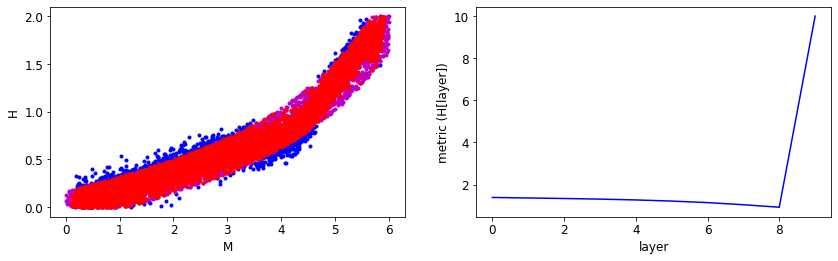

training epoch: 500,   loss: 0.009602077305316925
m2: 0.17894227802753448, lambda: -0.7569255232810974, alpha: 0.11762215197086334, beta: 0.0458797961473465
[ 1.38454676  1.35999012  1.33516514  1.30620837  1.26681542  1.21297681
  1.13939571  1.04004729  0.91990852 10.        ]


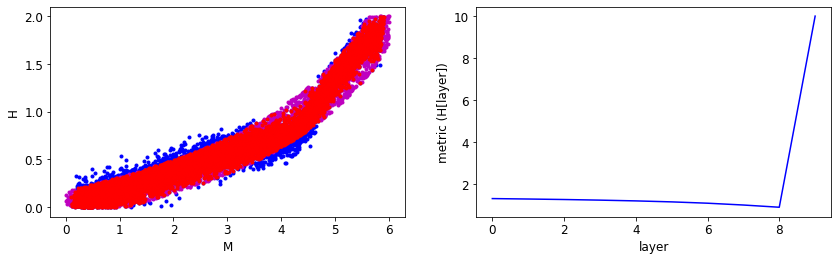

training epoch: 600,   loss: 0.009828677400946617
m2: 0.15458999574184418, lambda: -0.6810266375541687, alpha: 0.1245456337928772, beta: 0.04875152185559273
[ 1.31772101  1.29679513  1.27357078  1.2440002   1.20764542  1.16091907
  1.09779108  1.01144505  0.90559334 10.        ]


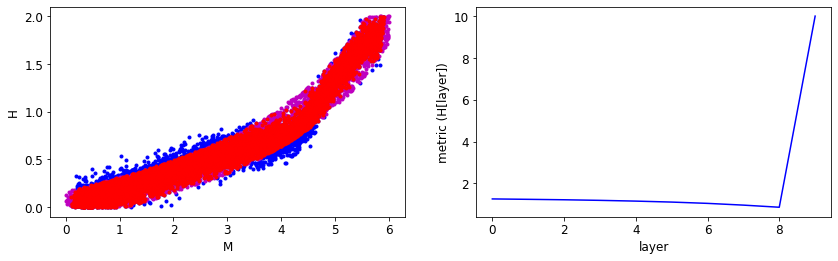

training epoch: 700,   loss: 0.009856104850769043
m2: 0.1393887996673584, lambda: -0.6110163331031799, alpha: 0.1316794604063034, beta: 0.05210759863257408
[ 1.25966108  1.24067438  1.21972966  1.19159961  1.15559924  1.10920227
  1.0472995   0.96371961  0.86224854 10.        ]


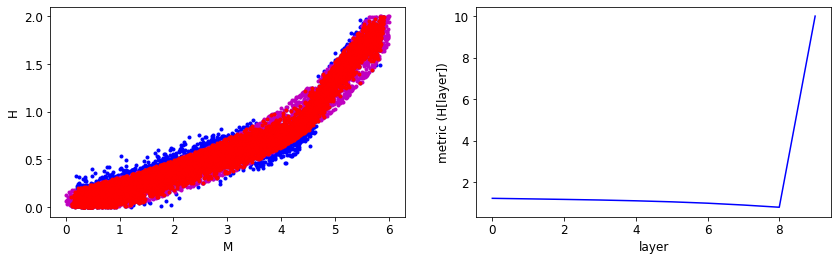

training epoch: 800,   loss: 0.009479904547333717
m2: 0.12502360343933105, lambda: -0.5462513566017151, alpha: 0.13574710488319397, beta: 0.05360884591937065
[ 1.21101153  1.18558252  1.15938449  1.12978518  1.09167778  1.04206574
  0.97640675  0.88785785  0.78091729 10.        ]


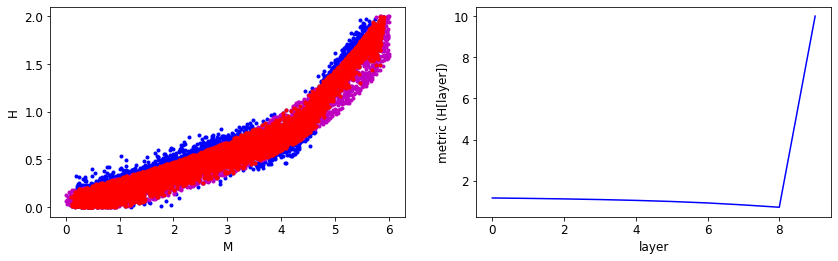

training epoch: 900,   loss: 0.009818725287914276
m2: 0.11522497236728668, lambda: -0.48723265528678894, alpha: 0.13866040110588074, beta: 0.05727018043398857
[ 1.16549957  1.14498818  1.11980307  1.08849406  1.04798138  0.9946022
  0.92343718  0.82825011  0.71497107 10.        ]


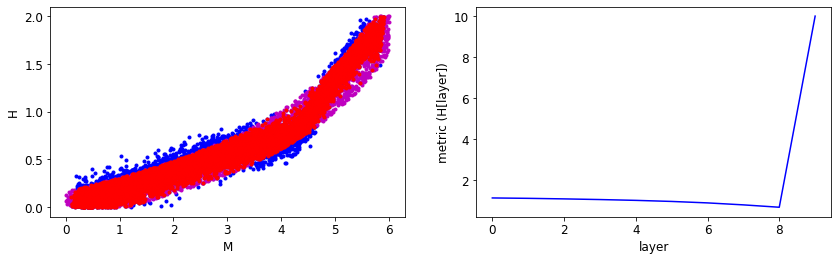

training epoch: 1000,   loss: 0.009692582301795483
m2: 0.1062597781419754, lambda: -0.44651296734809875, alpha: 0.1448369324207306, beta: 0.05863024294376373
[ 1.12447894  1.10574687  1.0785563   1.04643822  1.00674188  0.95417649
  0.88291836  0.78659624  0.6708855  10.        ]


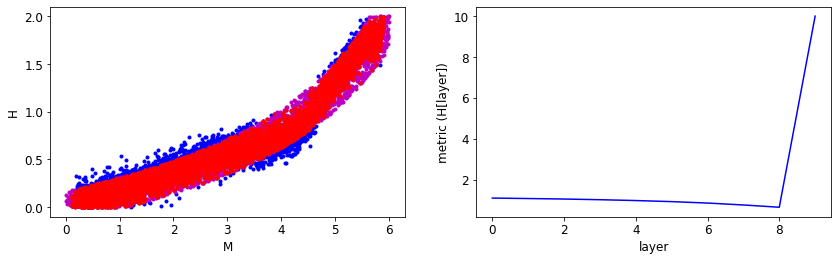

training epoch: 1100,   loss: 0.009638939052820206
m2: 0.09812892973423004, lambda: -0.4115348756313324, alpha: 0.1510070562362671, beta: 0.060212962329387665
[ 1.09417272  1.07179213  1.04712677  1.01455879  0.97333109  0.9203887
  0.85017037  0.75673258  0.64543766 10.        ]


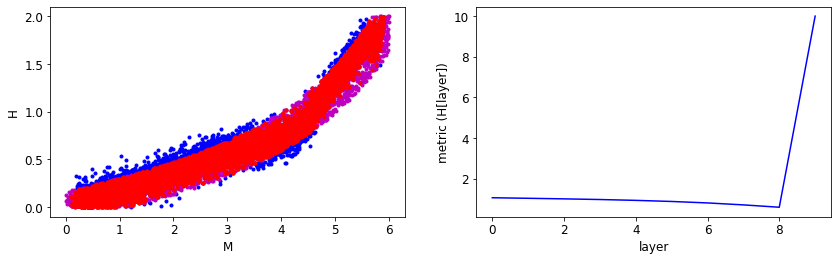

training epoch: 1200,   loss: 0.0096231484785676
m2: 0.0887664183974266, lambda: -0.38825857639312744, alpha: 0.15484821796417236, beta: 0.062380336225032806
[ 1.06871629  1.04199338  1.0137912   0.98138344  0.93980289  0.88574755
  0.81385201  0.71740741  0.60168898 10.        ]


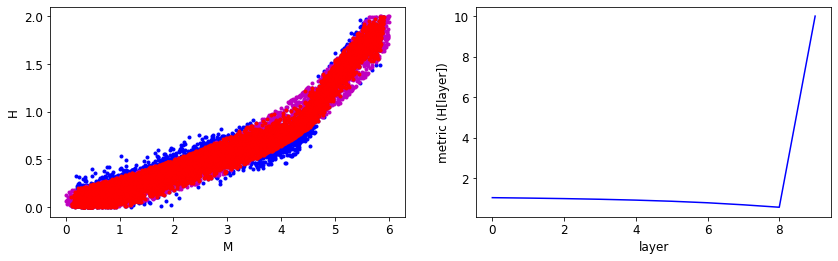

training epoch: 1300,   loss: 0.009602504782378674
m2: 0.09043854475021362, lambda: -0.3635565936565399, alpha: 0.157721608877182, beta: 0.062371060252189636
[ 1.04115891  1.02016735  0.99452007  0.96194059  0.91978198  0.86393654
  0.78893822  0.68833107  0.56830794 10.        ]


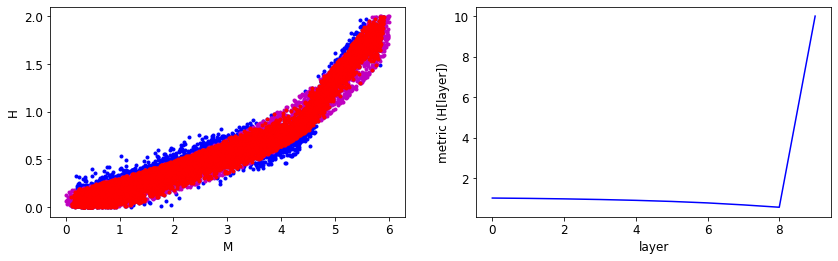

training epoch: 1400,   loss: 0.009557105600833893
m2: 0.08576725423336029, lambda: -0.34411534667015076, alpha: 0.16102191805839539, beta: 0.06444201618432999
[ 1.02567828  1.00914466  0.98496437  0.95366627  0.91258478  0.85834616
  0.78554976  0.68801588  0.57202601 10.        ]


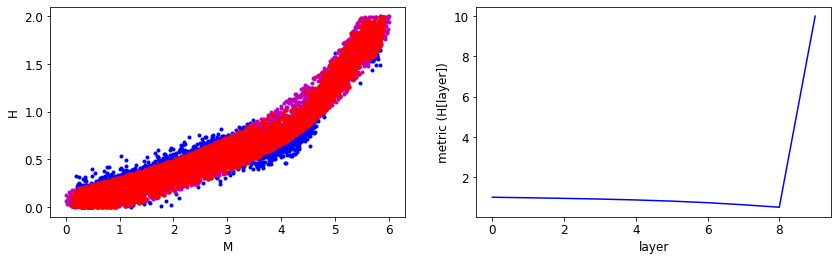

training epoch: 1500,   loss: 0.009670235216617584
m2: 0.0809113010764122, lambda: -0.34003499150276184, alpha: 0.16700352728366852, beta: 0.06451591104269028
[ 1.01200306  0.98623806  0.9570052   0.9220978   0.87759793  0.81979364
  0.74243933  0.63889664  0.51605999 10.        ]


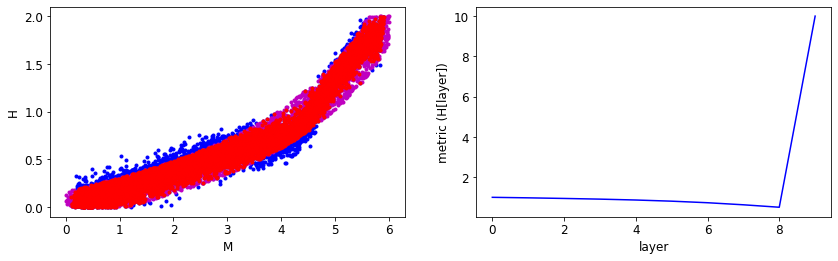

training epoch: 1600,   loss: 0.009682701900601387
m2: 0.07812076061964035, lambda: -0.32657700777053833, alpha: 0.16653728485107422, beta: 0.06596841663122177
[ 1.00106299  0.97547919  0.94512409  0.9110164   0.86748159  0.8095327
  0.73236465  0.62997103  0.5082621  10.        ]


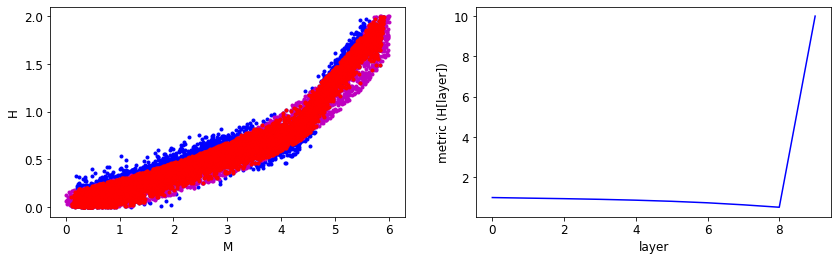

training epoch: 1700,   loss: 0.009623446501791477
m2: 0.07367824018001556, lambda: -0.31903862953186035, alpha: 0.16704988479614258, beta: 0.06756278872489929
[ 0.99230957  0.96373111  0.93702197  0.90419275  0.86191243  0.80632252
  0.73165995  0.63135868  0.51119971 10.        ]


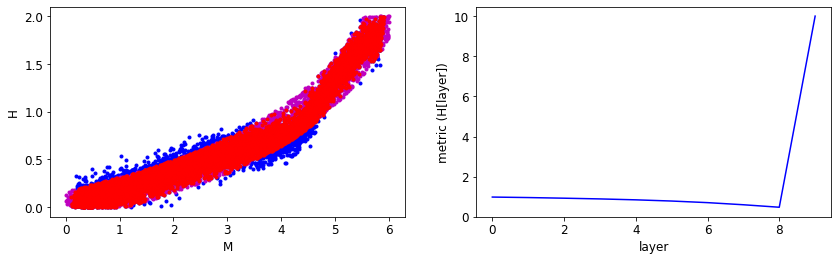

training epoch: 1800,   loss: 0.009615713730454445
m2: 0.07614006847143173, lambda: -0.317349374294281, alpha: 0.17026926577091217, beta: 0.06696893274784088
[ 0.98169643  0.95739251  0.92536873  0.88932967  0.84366351  0.78375196
  0.70414501  0.59846771  0.47442308 10.        ]


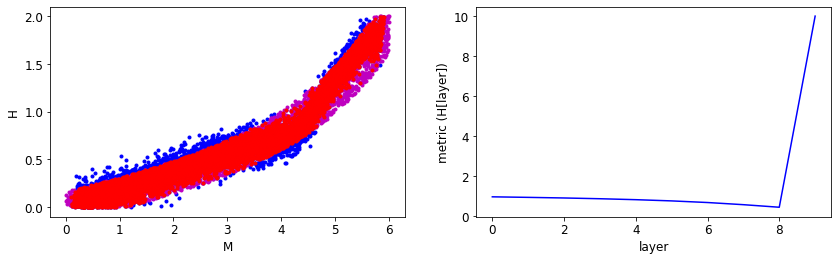

training epoch: 1900,   loss: 0.009663942269980907
m2: 0.0745798647403717, lambda: -0.3079818785190582, alpha: 0.16759835183620453, beta: 0.06759212166070938
[ 0.97688025  0.94981521  0.91945994  0.88149911  0.83426797  0.77336395
  0.6924451   0.58457398  0.45660931 10.        ]


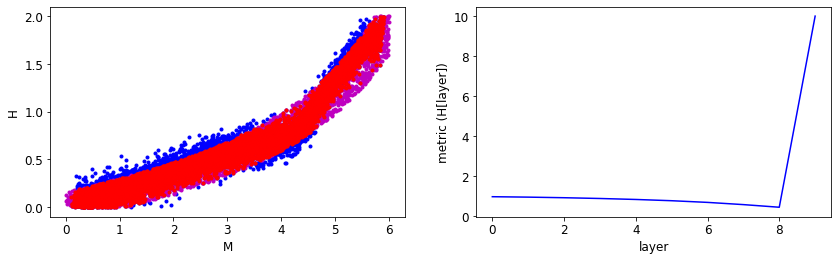

training epoch: 2000,   loss: 0.00978670734912157
m2: 0.07360959053039551, lambda: -0.30814847350120544, alpha: 0.1692383587360382, beta: 0.07013414800167084
[ 0.97182083  0.95060694  0.92122245  0.88274175  0.83408368  0.77125275
  0.68780351  0.57676095  0.44509733 10.        ]


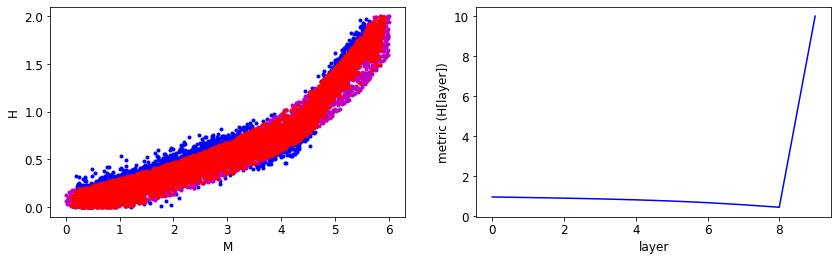

training epoch: 2100,   loss: 0.009595737792551517
m2: 0.07074207067489624, lambda: -0.30346769094467163, alpha: 0.16992159187793732, beta: 0.06885183602571487
[ 0.97078949  0.94156027  0.91113245  0.87421215  0.827443    0.76688993
  0.68688142  0.58139843  0.45730639 10.        ]


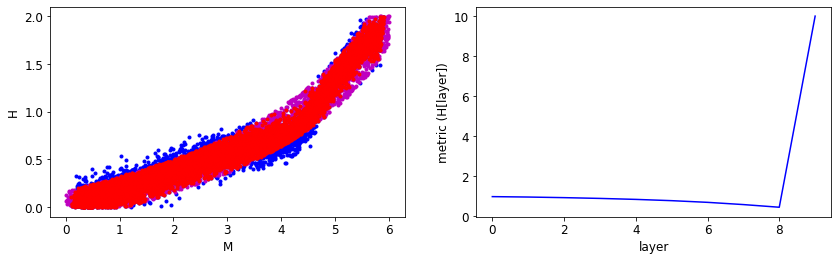

training epoch: 2200,   loss: 0.009692939929664135
m2: 0.07481927424669266, lambda: -0.29919299483299255, alpha: 0.16944876313209534, beta: 0.06659544259309769
[ 0.96357203  0.94290692  0.91264457  0.87398136  0.82503217  0.76145446
  0.6772598   0.56525314  0.43196917 10.        ]


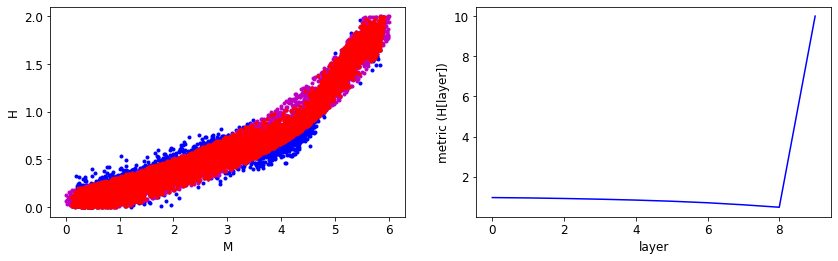

training epoch: 2300,   loss: 0.009607415646314621
m2: 0.0739808902144432, lambda: -0.29663339257240295, alpha: 0.172605961561203, beta: 0.06640663743019104
[ 0.96126425  0.94384211  0.91576797  0.88037336  0.83636558  0.77919328
  0.70304775  0.60126716  0.47970116 10.        ]


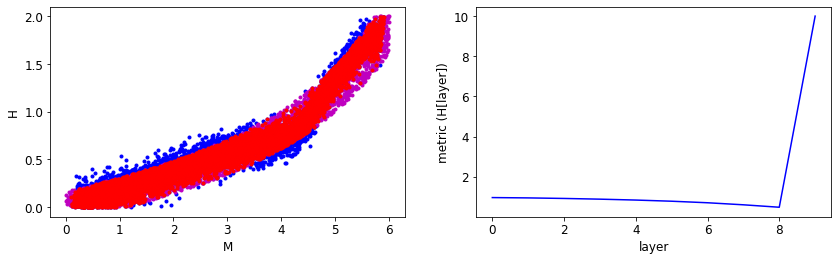

training epoch: 2400,   loss: 0.009432876482605934
m2: 0.07266770303249359, lambda: -0.292651504278183, alpha: 0.17034344375133514, beta: 0.06828996539115906
[ 0.96108913  0.94482106  0.91748822  0.88211471  0.83735269  0.77954036
  0.70299459  0.60106194  0.4794991  10.        ]


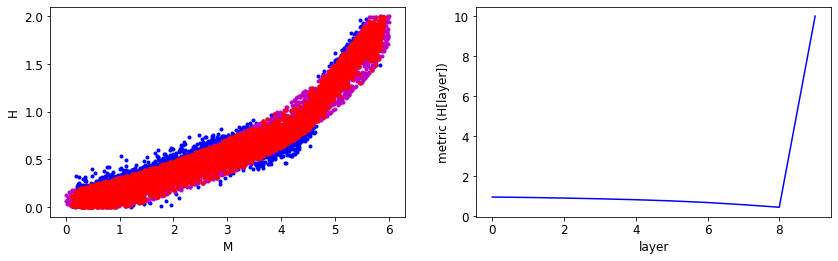

training epoch: 2500,   loss: 0.009712978266179562
m2: 0.07190744578838348, lambda: -0.29679542779922485, alpha: 0.1712949275970459, beta: 0.0681283175945282
[ 0.95838058  0.9381628   0.90762085  0.87104261  0.82550609  0.7655201
  0.68457603  0.57647085  0.44900993 10.        ]


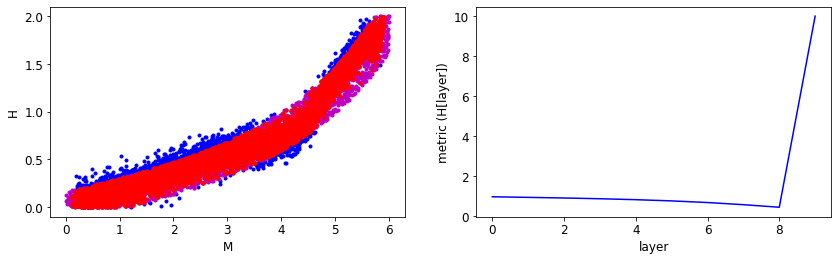

training epoch: 2600,   loss: 0.009764160960912704
m2: 0.06924667209386826, lambda: -0.2982504367828369, alpha: 0.17141160368919373, beta: 0.06931611150503159
[ 0.96053547  0.93145335  0.89981937  0.86273474  0.81573641  0.75446612
  0.67307788  0.56506014  0.43722624 10.        ]


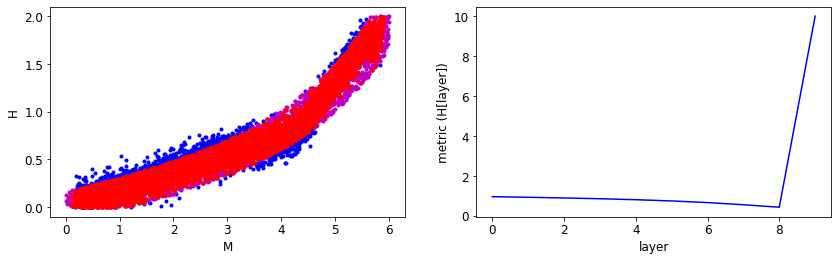

training epoch: 2700,   loss: 0.009826743975281715
m2: 0.06964035332202911, lambda: -0.2989151179790497, alpha: 0.17138512432575226, beta: 0.06851823627948761
[ 0.95758694  0.92723376  0.89344621  0.8546524   0.80627531  0.74400949
  0.66234189  0.55486429  0.42875996 10.        ]


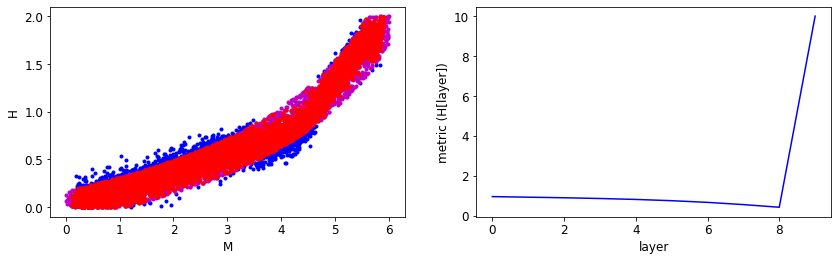

training epoch: 2800,   loss: 0.009586312808096409
m2: 0.07144926488399506, lambda: -0.2993272840976715, alpha: 0.1718883067369461, beta: 0.06807458400726318
[ 0.95488954  0.92648017  0.89694136  0.86014062  0.81285828  0.75018626
  0.66606963  0.55412704  0.42176834 10.        ]


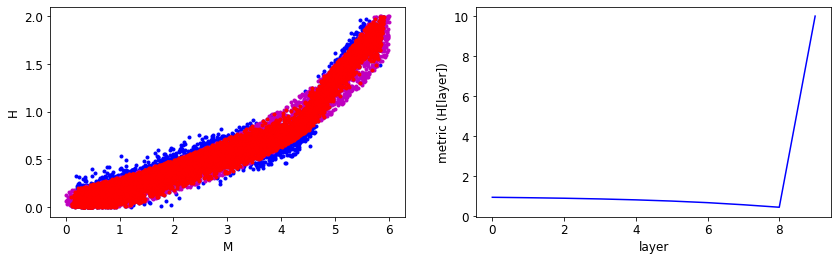

training epoch: 2900,   loss: 0.009521801955997944
m2: 0.07328227907419205, lambda: -0.29035353660583496, alpha: 0.16922016441822052, beta: 0.06734286993741989
[ 0.95407146  0.9325034   0.90679693  0.87166101  0.82569098  0.76552683
  0.6859898   0.58091623  0.45678255 10.        ]


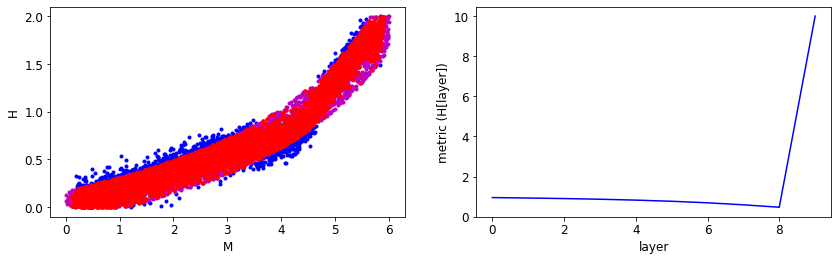

training epoch: 3000,   loss: 0.009924625046551228
m2: 0.07077419757843018, lambda: -0.2952430248260498, alpha: 0.17020739614963531, beta: 0.06708353012800217
[ 0.95278853  0.92920709  0.90288103  0.86922753  0.82529289  0.76785654
  0.69174981  0.5905391   0.46988711 10.        ]


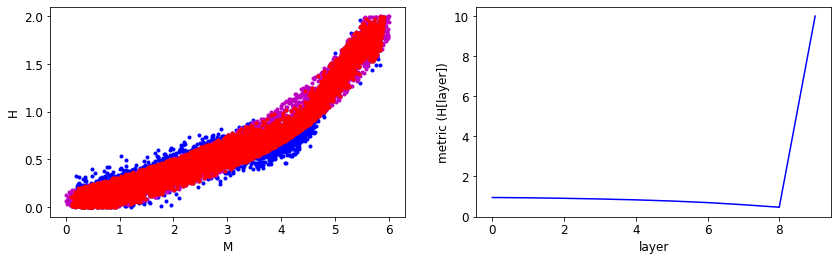

training epoch: 3100,   loss: 0.009532758966088295
m2: 0.07444579154253006, lambda: -0.29615873098373413, alpha: 0.17154203355312347, beta: 0.06688718497753143
[ 0.94882506  0.93346894  0.9090116   0.87525201  0.83143908  0.77347916
  0.69487524  0.58873326  0.46269661 10.        ]


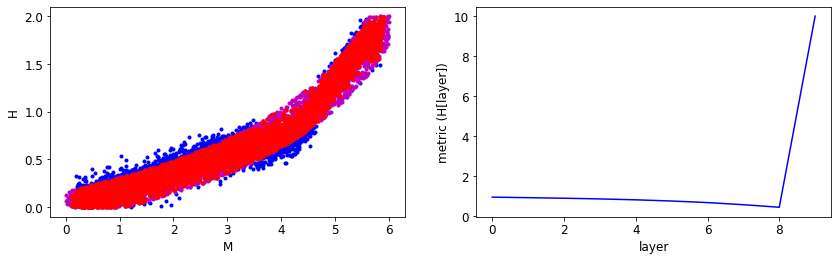

training epoch: 3200,   loss: 0.009854692965745926
m2: 0.07117899507284164, lambda: -0.29846063256263733, alpha: 0.17194756865501404, beta: 0.06855500489473343
[ 0.95321548  0.92713815  0.89956075  0.86473316  0.81932712  0.76005214
  0.6814363   0.57581741  0.44874004 10.        ]


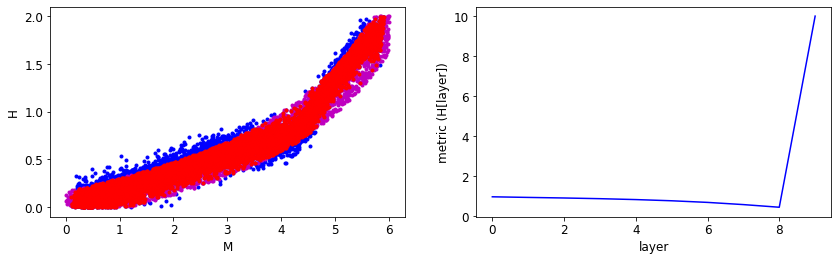

training epoch: 3300,   loss: 0.009701556526124477
m2: 0.06812676787376404, lambda: -0.3006398677825928, alpha: 0.17111676931381226, beta: 0.06956439465284348
[ 0.9547109   0.92389685  0.89539468  0.86067462  0.81569237  0.75584662
  0.67461371  0.56439012  0.43184391 10.        ]


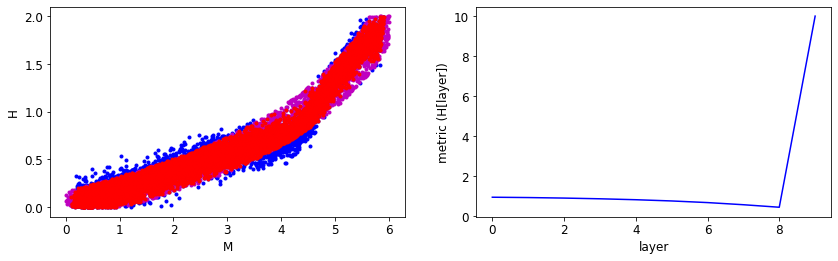

training epoch: 3400,   loss: 0.009244121611118317
m2: 0.07516057789325714, lambda: -0.29274752736091614, alpha: 0.16952331364154816, beta: 0.06739591807126999
[ 0.94952977  0.93287891  0.90681326  0.87125999  0.82450747  0.76304328
  0.68169832  0.57442838  0.44873604 10.        ]


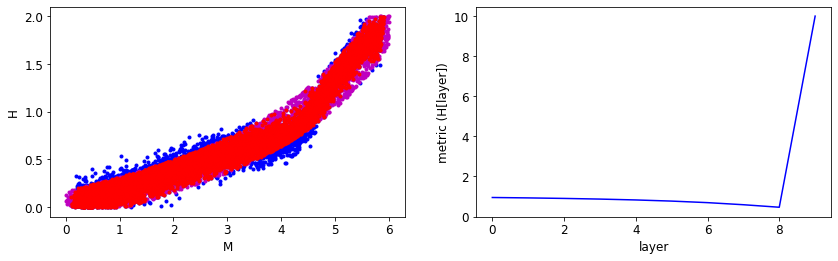

training epoch: 3500,   loss: 0.009611865505576134
m2: 0.07229330390691757, lambda: -0.29540660977363586, alpha: 0.1707218736410141, beta: 0.06736912578344345
[ 0.95060533  0.93045348  0.90450752  0.87137687  0.82819515  0.77107555
  0.69406724  0.58988672  0.46432921 10.        ]


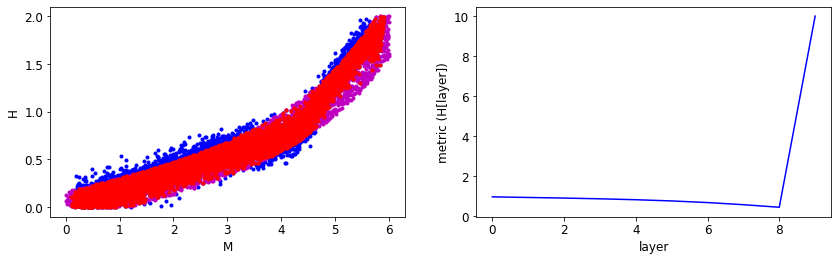

training epoch: 3600,   loss: 0.009971034713089466
m2: 0.06914610415697098, lambda: -0.2951217591762543, alpha: 0.16951139271259308, beta: 0.06883631646633148
[ 0.95578301  0.92491549  0.89453989  0.85814238  0.8118031   0.75118303
  0.67042845  0.56287664  0.43566877 10.        ]


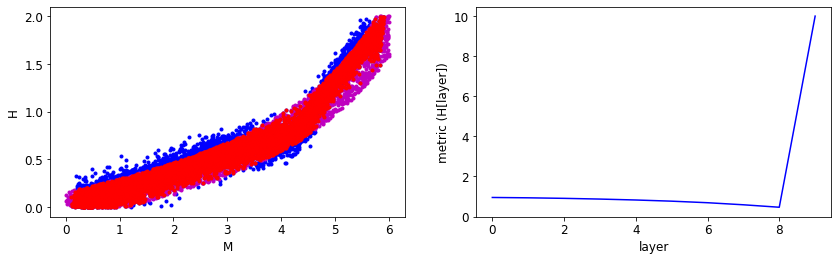

training epoch: 3700,   loss: 0.009595030918717384
m2: 0.07071065157651901, lambda: -0.2958337664604187, alpha: 0.17063362896442413, beta: 0.07111044973134995
[ 0.95306349  0.93582648  0.90918124  0.87280566  0.82696289  0.76833504
  0.69097215  0.58800071  0.46532962 10.        ]


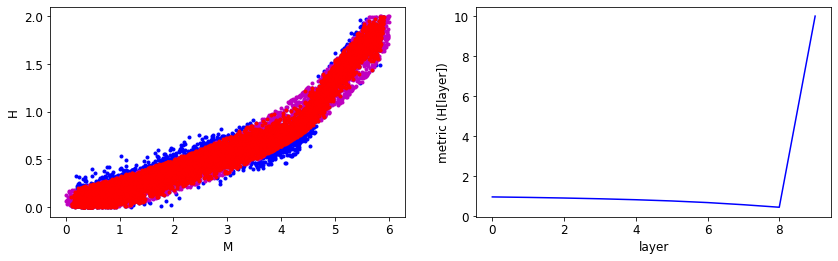

training epoch: 3800,   loss: 0.009661688469350338
m2: 0.07218553125858307, lambda: -0.2943377196788788, alpha: 0.17027106881141663, beta: 0.06682571023702621
[ 0.95223528  0.92808533  0.8971628   0.8591556   0.81159967  0.75043392
  0.66945142  0.56199437  0.43556431 10.        ]


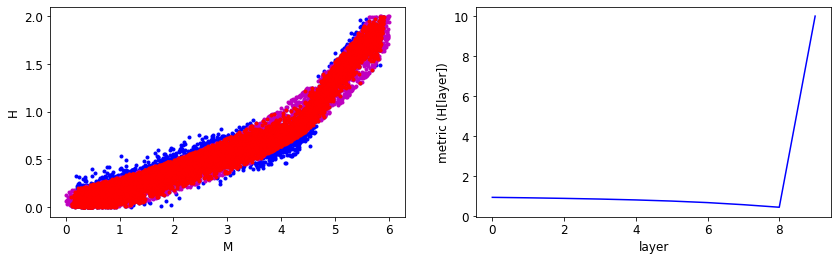

training epoch: 3900,   loss: 0.00939239002764225
m2: 0.07145528495311737, lambda: -0.2926553189754486, alpha: 0.17100673913955688, beta: 0.06715127825737
[ 0.95178068  0.9287563   0.90045446  0.8663606   0.82287478  0.7661947
  0.68962115  0.58500516  0.45769656 10.        ]


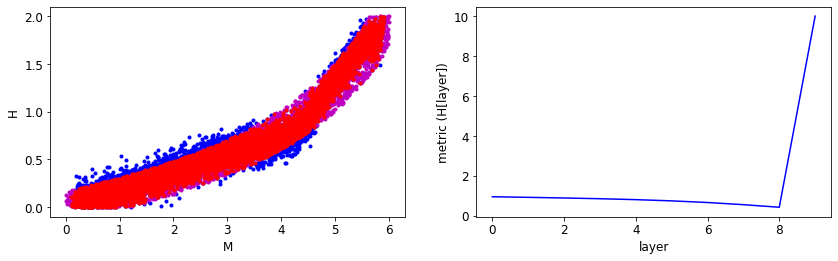

training epoch: 4000,   loss: 0.010034867562353611
m2: 0.06901063770055771, lambda: -0.3015328049659729, alpha: 0.1714428961277008, beta: 0.06873947381973267
[ 0.95252264  0.92378598  0.89085263  0.85426563  0.80793941  0.74673963
  0.6648761   0.55587596  0.42734542 10.        ]


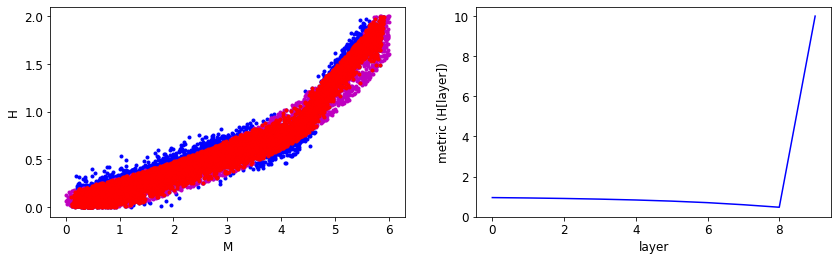

training epoch: 4100,   loss: 0.009615272283554077
m2: 0.07119883596897125, lambda: -0.29512885212898254, alpha: 0.1696043759584427, beta: 0.06928955018520355
[ 0.950091    0.93146896  0.90614396  0.87315273  0.83038718  0.77381384
  0.69739968  0.59374285  0.46847001 10.        ]


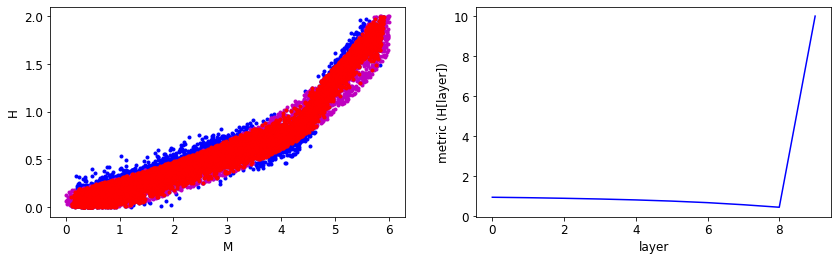

training epoch: 4200,   loss: 0.009676753543317318
m2: 0.07063933461904526, lambda: -0.2956172227859497, alpha: 0.17041538655757904, beta: 0.06914117187261581
[ 0.95220828  0.92993867  0.9001047   0.86431193  0.81878823  0.76007903
  0.68240738  0.57823062  0.45289296 10.        ]


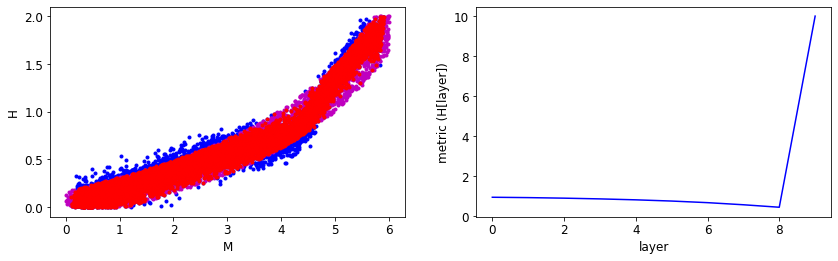

training epoch: 4300,   loss: 0.009582164697349072
m2: 0.07339247316122055, lambda: -0.2934550642967224, alpha: 0.1698439121246338, beta: 0.06883161514997482
[ 0.9509266   0.93305027  0.9055692   0.86905718  0.82206386  0.76120281
  0.68114489  0.57585758  0.45187524 10.        ]


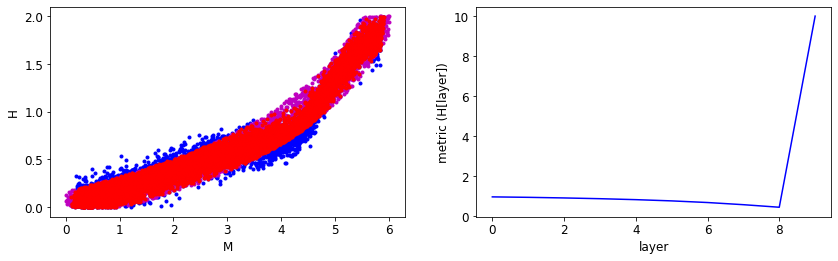

training epoch: 4400,   loss: 0.009953915141522884
m2: 0.0743943527340889, lambda: -0.30058053135871887, alpha: 0.17366032302379608, beta: 0.06885617226362228
[ 0.95137912  0.92895657  0.89823478  0.86038649  0.81265014  0.75071442
  0.66886175  0.56047446  0.43254921 10.        ]


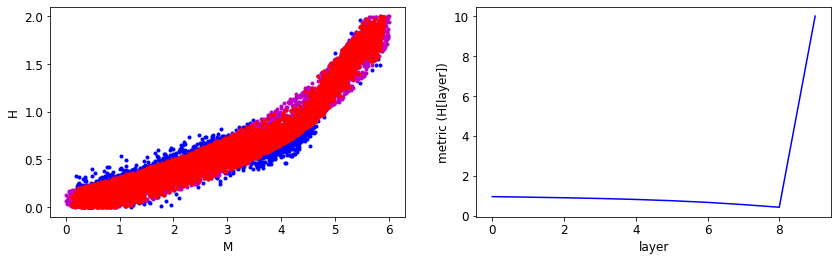

training epoch: 4500,   loss: 0.00977523997426033
m2: 0.07387688010931015, lambda: -0.2969420850276947, alpha: 0.17119596898555756, beta: 0.06751540303230286
[ 0.95114839  0.92352521  0.89474726  0.8575021   0.80945677  0.74646944
  0.66252798  0.55085909  0.41852653 10.        ]


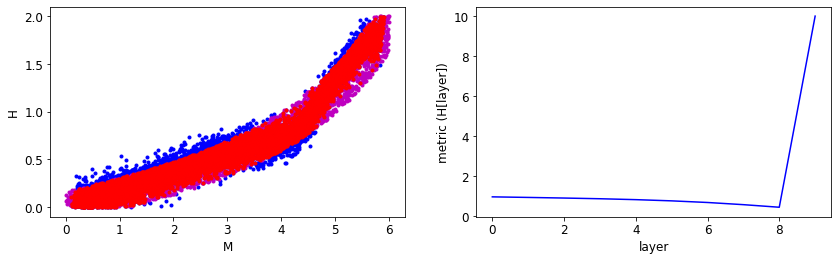

training epoch: 4600,   loss: 0.00989639014005661
m2: 0.0693812221288681, lambda: -0.29779505729675293, alpha: 0.1710350662469864, beta: 0.06950049102306366
[ 0.95348775  0.92488641  0.8940354   0.85899818  0.81371319  0.75312334
  0.671561    0.56259555  0.43345964 10.        ]


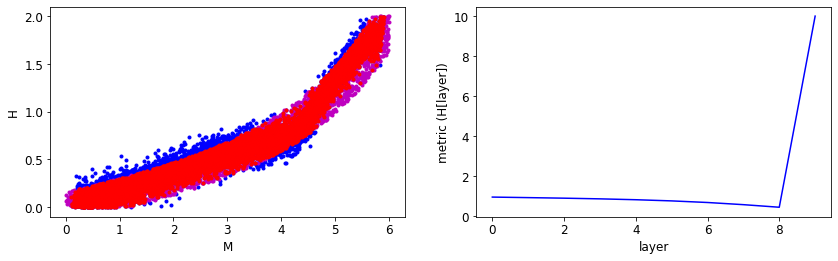

training epoch: 4700,   loss: 0.009565452113747597
m2: 0.06742015480995178, lambda: -0.2992810308933258, alpha: 0.17245100438594818, beta: 0.06996416300535202
[ 0.95350242  0.9268496   0.89892799  0.86509901  0.8216843   0.76311284
  0.68303049  0.57473975  0.44572091 10.        ]


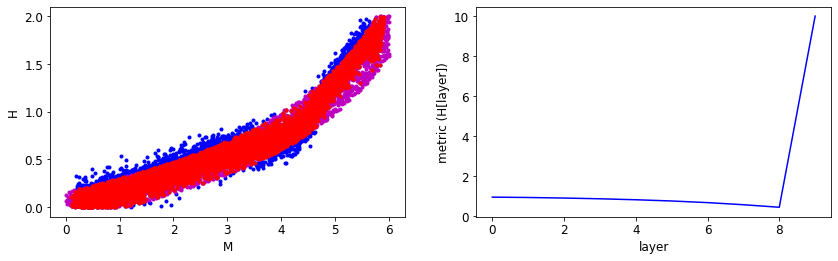

training epoch: 4800,   loss: 0.009729727171361446
m2: 0.0724618211388588, lambda: -0.29150012135505676, alpha: 0.17017114162445068, beta: 0.07030995190143585
[ 0.95418155  0.93641883  0.90865189  0.87111205  0.82310331  0.76144761
  0.68057859  0.5742591   0.44887349 10.        ]


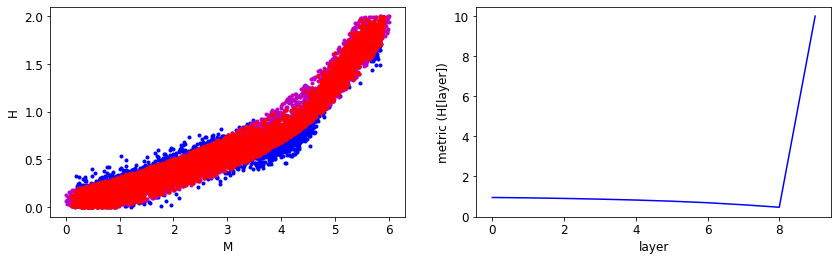

training epoch: 4900,   loss: 0.009555145166814327
m2: 0.07261770218610764, lambda: -0.29706084728240967, alpha: 0.17567873001098633, beta: 0.06758392602205276
[ 0.95280743  0.93433774  0.90565401  0.87053585  0.82605165  0.76824474
  0.69146806  0.58887196  0.46641979 10.        ]


In [21]:
total_epoch=5000
show_epoch_each=100
for epoch in range (total_epoch):
    batches=iter(train_d_loader)
    train_loss = 0.0
    for (b_phi, b_pi, b_ans) in batches:
        phi, pi, ans = Variable(b_phi), Variable(b_pi), Variable(b_ans)
        loss = Test.loss(phi=phi, pi=pi, answer=ans, reg_coef_list=regularization_coeffs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.data[0]
    if np.isnan(train_loss)==True: break
        
    if epoch % show_epoch_each == 0:
        nx, ny, px, py, Hs = plot_phase_and_metric(threshold=0.1, eta_or_layer='layer',
                                         positive_H_M_F=Positive_HM, negative_H_M_F=Negative_HM, Net=Test)
        print ("training epoch: {},   loss: {}".format(epoch, train_loss / len(train_d_loader)))
        print ("m2: {}, lambda: {}, alpha: {}, beta: {}".format(Test.show_m2().data.numpy()[0], Test.show_lamb().data.numpy()[0], Test.show_alpha().data.numpy()[0], Test.show_beta().data.numpy()[0]))
        print(np.array([v[0] for v in Hs]))